<a href="https://colab.research.google.com/github/hlapin/DHTeaching/blob/master/Getting_Started_With_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the text
We are going to be working with the Federalist Papers  
We need to:
1. Download a zip file from github (Programming Historian repository)
2. Unzip it and
3. Unpack the files in a local folder [local to Colab]



In [ ]:
import requests, io, zipfile, os
os.chdir ('/content/') # changes working directory on local machine
r = requests.get('https://github.com/programminghistorian/ph-submissions/blob/gh-pages/assets/introduction-to-stylometry-with-python/stylometry-federalist.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall() 



There is now a local file on the virtual machine you are using called `data` with the files   
You can check that in the tools in the left hand toolbar   
However, let's set the working directory to that directory confirm it and list its contents
 

In [ ]:
os.chdir ('/content/data') # changes working directory on local machine
print ('current working directory:')
print (os.getcwd()) # prints path to current working directory 
print ('file list:')
%ls #instruction to list file directory

# did you not get a file list? a directory? if not we have a problem.

## Text to Dataframe
Now we are going to read the complete work `federalist.txt` into one variable (`papersAll`) and each of the individual chapters into a table (a pandas dataframe, `dfPapers`) where each row is a document and that has the column headings `file_name` and `text`.

In [ ]:
# 
import pandas as pd # pandas is a data structure library
import glob

with open ("federalist.txt","r") as f:
  papersAll = f.read().replace('\n', ' ')

print(papersAll[:100]) #print first 100 chars to check

# create a dataframe with each document as a row
results = {"file_name":[],"text":[]}
for item in glob.glob('*[0-9].txt'):  # read only files with numerals
   short = item.split('.')[0]
   with open(item, "r") as file_open:
     results["file_name"].append(short)
     results["text"].append(file_open.read().replace('\n', ' '))
dfPapers = pd.DataFrame(results)

#let's check that we got the documents into shape
print(dfPapers.head)           

## A Bit of Cleanup
Let's remove punctuation and convert all upper case to lower case, and then print a sample of our data to if we got it right.  
> *Regular expressions* refers to a set of operations on text that can be defined by patterns (a valid email address is an unbroken string, followed by '@' followed by a domain and a valid suffix or suffixes (.org, .edu, .ac.uk).




In [ ]:
import re #re is the module that does regular expression operations

# note that pandas allows us to operate on all the cells in a column
# of a dataframe by filtering by column label: dfPapers['text'] 

# regularize spacing: 
# replace one or more line breaks or spaces with single space
dfPapers['text'] = dfPapers['text'].map(lambda x: re.sub('\s+', ' ', x))

# remove sentence punctuation. This time replace with no space
dfPapers['text'] = dfPapers['text'].map(lambda x: re.sub('[\(\(\:;,\.!?]', '', x))

# convert characters to lower case
dfPapers['text'] = dfPapers['text'].map(lambda x: x.lower())

#let's check that we got the documents into shape
print(dfPapers.head)     

# Some Exploratory Analysis
First we are going to do some exploratory text analysis by making a word cloud.  

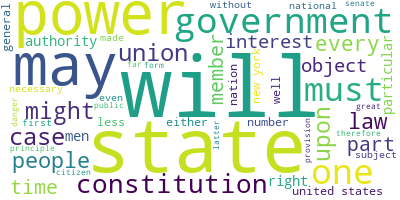

In [ ]:
from wordcloud import WordCloud


# code adapted from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Join the different processed titles together into one long text.
long_string = ','.join(list(dfPapers['text'].values))

# Create a WordCloud object
# You can change the parameters below
wordcloud = WordCloud(background_color="white", 
                        max_words=50, 
                        contour_width=3, 
                        contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()


# Topic Modelling

## Latent Dirichlet Allocation (LDA)
A document is a collection of topics.
Topics are lists of words that appear frequently in those topics  
A recipe has:
* some words having to do with `food` (milk, eggs, a live badger)
* some having to do with `operations` (mix, heat, beat, burn)
* it will also include a bunch of other stuff (esp. on a food blog) - family, geography, calendar; perhaps gender, ethnicity.  

LDA uses a machine learning algorithm to calculate a pre-set number of topics and by looking at what words tend to go together tries to learn the underlying topics.  
The topic listings are not mutually exclusive; the same word can appear in more than one topic.

## How it works

> Still to do



## Topic Modeling Operations
We are running MALLET, a java program, through the python gensim library. This seems to give getter results than gensim's own lda algorithm.
We are then going to convert that model into gensim's own model so that we can use visualization tools.  
1. Import/update various Python libraries we will be using
2. Import MALLET and deploy it. 
3. Prepare our data for further processing
1. Create the "corpus" and the "dictionary" required  for analysis
2. Create an LDA model

## Import/update libraries

In [ ]:
# much of the following repurposes:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Bunch o' modules we will be using
import numpy as np  # a library for arrays
from pprint import pprint # formats output ("pretty-prints")

# Gensim package for data text analysis
!pip install --upgrade gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# we are also going to want  remove "stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# run with the following un-commented to see what the stopwords are
# these are based on contemporary English; we'd need to do some linguistic work
# for the Federalist Papers

# print(len(stop_words))
# print(stop_words)


# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Prepare our data for processing

In [ ]:
# Get our data in the form of a list in which every FP document is 
# Represented as a list of words.

data = dfPapers['text'].values.tolist()
# uncommented below will print the text of the first text
# pprint(data[:1])

#now remove stopwords
def paper_to_words(papers):
  """ Our first function! Yay!
      this function does the tokenization"""
  for paper in papers:
    yield(gensim.utils.simple_preprocess(str(paper), deacc=True))

def remove_stopwords(texts):
  """ This function checks for and removes stopwords"""
  return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

      
data_words = list(paper_to_words(data))
data_words_no_stops = remove_stopwords(data_words)

# run with the following un-commented to see the first document
# print(data_words_no_stops[:1])


## Prepare the "corpus" and "dictionary" required as input

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_no_stops)

# Create Corpus
texts = data_words_no_stops

# Term Document Frequency: converts orderd string to "bag of words"
corpus = [id2word.doc2bow(text) for text in texts]

# # viewing data
# # uncomment and run to view
# corpus
# print(corpus[:1])

# # Human readable format of corpus (term-frequency)
# print(len(id2word))
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


## Get, deploy MALLET; if necessary get Java.

In [ ]:
# # un-comment if you need to update java
# def install_java():
#   !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
#   os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
#   !java -version       #check java version
# install_java()

# getting Mallet
r = requests.get('http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('/content') 

!chmod 764 /content/mallet-2.0.8/bin/mallet #gives owner (you) execute rights (7)

# just in case we need to set the environmental variables.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ['MALLET_HOME'] = '/content/data/mallet-2.0.8/'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 



## Build and view the LDA model in Mallet

In [ ]:

from gensim.models.wrappers import LdaMallet

# can experiment with the number of topics, and the optimize interval
num_topics = 50 # 20 is the default
optimize_interval = 10 ## allows mallet to make some topics more prominent than others
                       ## MALLET specs say "10 is reasonable"
                       ## reportedly 20-40
                       ## set to zero to turn off

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             num_topics=num_topics, 
                                             optimize_interval=optimize_interval,
                                             id2word=id2word)

# Show Topics and coherence score
pprint(ldamallet.show_topics(formatted=False))
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=data_words_no_stops, 
                                           dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

## Let's do some basic examination

The next block builds a table that gives the document mostly closely associated with a topic
> To do: 
* Text operations on original data structure to make sure that sort order is the same as alpha/numerical
* Extract publication name (Federalist no. ##) to use in table

In [ ]:

%load_ext google.colab.data_table

def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data_words_no_stops):
    # Init output
    paper_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                paper_topics_df = paper_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    paper_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # to align MALLET topic indexing [1-based]  with gensim/Python [0-based]
    paper_topics_df['Dominant_Topic'] = paper_topics_df['Dominant_Topic'] + 1

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    # paper_topics_df = pd.concat([paper_topics_df, contents], axis=1)
    return(paper_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data_words_no_stops)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic

## Reformat and view in pyLDAvis

Repackage our MALLET model as a gensim model so we can use the tools  

Lambda metric: proportion of frequency in overall model to "frequency"  
**0 [Red]:** Sorts only by the frequency of the word in the overall topic model  
**1 [Blue]:** Sorts only by the impact the word on the selected model
**lambda:** 
> "the “the ratio of a term’s probability within a topic to its marginal probability across the corpus,” or the ratio between its red bar and blue bar"  
[https://we1s.ucsb.edu/research/we1s-tools-and-software/topic-model-observatory/tmo-guide/tmo-guide-pyldavis/]



In [ ]:
# makes use of https://medium.com/@jobethmuncy/formatting-pyldavis-and-mallet-model-7c0d00061b67

# convert to gensim LDA model
mallet_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet_lda_model, corpus, id2word,sort_topics = False)
pyLDAvis.display(vis)


# Stylometry and Author Identification
> Adapted from "Programming Historian"   
https://doi.org/10.46430/phen0078